# 第三个数据集：ANDI_90_120

来自Dr.SheN贴心的注释：

每次训练的时候，请在上方选择：Kernel-Restart and Run All哦，不然可能出现一些小问题

默认算法：线性回归

默认数据集：PPMI

默认training set：validation set：test set = 8：1：1

默认优化算法：SGD

默认loss：MSELoss（如果是深度方法，由于是二分类问题，建议改成BCE Loss）

这份代码默认实现的是线性回归的训练代码，如果要改成深度方法的代码，要注意outputs = net(inputs)的前向传播的维度和输出。

## 数据集探索

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
data = sio.loadmat('ADNI_90_120_fMRI.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Sep 15 16:11:13 2021',
 '__version__': '1.0',
 '__globals__': [],
 'AD': array([[[ 17.32221045,  35.2183282 ,  31.41239062, ...,  15.83965103,
           12.02788701,  -2.11720996],
         [ -1.84803002,  32.25945929,  41.2600806 , ...,   6.20091222,
            1.65978509, -11.0913046 ],
         [ 11.88802015,  27.52254262,  16.81859297, ..., -15.47520737,
          -21.60318855, -13.39308646],
         ...,
         [ 19.39172209,  63.24957925, 119.79025766, ..., -47.09657481,
          -44.87948125,  -8.14558937],
         [  4.02395296,   3.80404437,   9.57548748, ..., -87.7656772 ,
          -56.30940354,  12.80995751],
         [ 22.53289972,  33.2054774 ,  44.3151234 , ..., -43.26276103,
          -25.95300174,   7.71252908]],
 
        [[ 25.86615183,  31.10776595,  29.7348211 , ..., -51.80237018,
          -50.24910016, -50.76854907],
         [-28.6080813 , -17.08629953,  -2.61494045, ..., -15.6498464

In [3]:
x_positive = data['NC']
x_negative = data['AD']
x_fake_positive = data['EMCI']
x_fake_negative = data['LMCI']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
y_fake_positive = np.ones(x_fake_positive.shape[0])
y_fake_negative = np.zeros(x_negative.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('没有加伪样本的时候有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = np.prod(x_positive.shape[1]**2)
num_x_fake_pos = x_fake_positive.shape[0]
num_x_fake_neg = x_fake_negative.shape[0]
x_total_faked = np.concatenate((x_positive, x_fake_positive, x_fake_negative, x_negative), axis=0).astype(np.float)
y_total_faked = np.concatenate((y_positive, y_fake_positive, y_fake_negative, y_negative), axis=0).astype(np.float)
num_fake_total = x_total_faked.shape[0]
num_total = x_total.shape[0]
print('加了伪样本之后有{}个正样本，有{}个负样本，一共有{}个样本'.format(num_x_fake_pos+num_x_pos, num_x_fake_neg+num_x_neg, num_fake_total))
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)

没有加伪样本的时候有48个正样本，有59个负样本，一共有107个样本
加了伪样本之后有104个正样本，有102个负样本，一共有206个样本
(48, 90, 120) (59, 90, 120) (107, 90, 120) (48,) 59 48 8100


In [4]:
# x_total_faked

## 利用TSNE和PCA的可视化，发现几乎不具有线性可分性

In [5]:
x_tsne = TSNE(n_components=2).fit_transform(x_total.reshape(num_total, -1))
print(x_tsne.shape)

(107, 2)


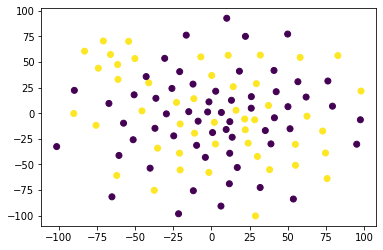

In [6]:
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c = list(y_total))

In [7]:
x_pca = PCA(n_components=2).fit_transform(x_total.reshape(num_total, -1))
print(x_pca.shape)

(107, 2)


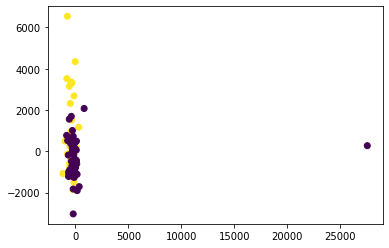

In [8]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c = list(y_total))

## 数据预处理（划分train/test dataset和载入dataloader）

### 数据预处理第一步，计算相关系数

In [9]:
import torch
def corrcoef(input):
    """传入一个tensor格式的矩阵x(x.shape(m,n))，输出其相关系数矩阵"""
    output = []
    for index, x in enumerate(input):
        f = (x.shape[0] - 1) / x.shape[0]      # 方差调整系数
        x_reducemean = x - np.mean(x, axis=0)
        numerator = np.matmul(x_reducemean.T, x_reducemean) / x.shape[0]
        var_ = x.var(axis=0).reshape(x.shape[1], 1)
        denominator = np.sqrt(np.matmul(var_, var_.T)) * f
        output.append(numerator / denominator)
    return output
pearson = corrcoef(x_total.reshape(107, 120, 90))
pearson = np.array(pearson).reshape(107, -1)
print(pearson.shape)
x_total = pearson

(107, 8100)


### 数据预处理第二步，划分t/t dataset和载入dataloader

In [27]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import random
random.seed(1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
################# batch_size也是一个超参数，第一个调整的参数就是batch_size,可选：1，2，4，8，16，32。
batch_size = 4

train_size = int(0.8*x_total.shape[0])
test_size = int(0.9*x_total.shape[0])

mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
random.shuffle(mixed)
# print(mixed)
x_train = mixed[:train_size, :dim_input]
y_train = mixed[:train_size, dim_input:]
print(x_train.shape, y_train.shape)
x_val = mixed[train_size:test_size, :dim_input]
y_val = mixed[train_size:test_size, dim_input:]
print(x_val.shape, y_val.shape)
x_test = mixed[test_size:, :dim_input]
y_test = mixed[test_size:, dim_input:]
print(x_test.shape, y_test.shape)

# transform = transforms.Compose([
#     transforms.Normalize(0.5, 0.5)
# ])
train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
# print(train_data[0][0].dtype)
val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
test_loader = Data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True, num_workers=1)
total_loader = Data.DataLoader(dataset = Data.TensorDataset(torch.Tensor(mixed[:,:dim_input]), torch.Tensor(mixed[:, dim_input:])), batch_size = batch_size, shuffle=True, num_workers=1)
print(len(train_data), len(val_data), len(test_data))

(85, 8100) (85, 1)
(11, 8100) (11, 1)
(11, 8100) (11, 1)
85 11 11


下面只需要用train_loader作为迭代器，用x_val,y_val（迭代器val_loader）来调参，当在x_val和y_val上达到最优的时候，在x_test(test_loader)上测试一次，作为一个算法的最终结果

In [28]:
########### 用于eval，非必要不改动
########### 敏感性即召回率，true positive rate = TP/(TP+FN)
########### 特异度为true negative rate = TN/(FP+TN)
def evaluate_accuracy(loader, net):
    net.eval()
    sum_all = 0
    sum_acc = 0
    FN = 0
    TN = 0
    TP = 0
    FP = 0
    
    for index, (data, label) in enumerate(loader):
        with torch.no_grad():
            data = Variable(data, requires_grad=True).to(device)
            label = Variable(label, requires_grad=True).to(device)
        outputs = (net(data) > 0.5).type(torch.float)
#         print(outputs.shape, label.shape)
        sum_acc += torch.sum(outputs.argmax(0) == label)
        for i in range(outputs.shape[0]):
            if outputs[i, 0] == label[i] and label[i] == 1:
                TP += 1
            elif outputs[i, 0] == label[i] and label[i] == 0:
                TN += 1
            elif outputs[i, 0] != label[i] and label[i] == 1:
                FN += 1
            else:
                FP += 1
        sum_all += data.shape[0]
    print('total validation set data:{}, numbers of accurately labeled data:{}'.format(sum_all, sum_acc.detach()))
    acc = sum_acc / sum_all
    net.train()
    sensitivity = TP / (TP + FN)
    specificity = TN / (FP + TN)
    return acc, sensitivity, specificity

## 实现算法一（传统方法）

In [12]:
##############在class里面定义自己的算法，xxxx是算法的名字。
class xxxx(nn.Module):
    def __init__(self, n_feature):
        super(xxxx, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    
        self.init_weights()

    def init_weights(self):
        """Xavier initialization for the fully connected layer
        """
        self.linear.weight.data.uniform_(-1, 1)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        y = self.linear(x)
        return torch.sigmoid(y)
    
# net = LinearNet(dim_input).to(device)
# print(net) # 使用print可以打印出网络的结构

## 实现算法二（传统方法/深度方法）

In [13]:
# ##############在class里面定义自己的算法，xxxx是算法的名字。
# class xxxx(nn.Module):
#     def __init__(self, n_feature):
#         super(xxxx, self).__init__()
#         self.linear = nn.Linear(n_feature, 1)
    
#         self.init_weights()

#     def init_weights(self):
#         """Xavier initialization for the fully connected layer
#         """
#         self.linear.weight.data.uniform_(-1, 1)
#         self.linear.bias.data.fill_(0)

#     def forward(self, x):
#         y = self.linear(x)
#         return torch.sigmoid(y)
    
# # net = LinearNet(dim_input).to(device)
# # print(net) # 使用print可以打印出网络的结构

## 实现算法三（深度方法）

In [14]:
# ##############在class里面定义自己的算法，xxxx是算法的名字。
# class xxxx(nn.Module):
#     def __init__(self, n_feature):
#         super(xxxx, self).__init__()
#         self.linear = nn.Linear(n_feature, 1)
    
#         self.init_weights()

#     def init_weights(self):
#         """Xavier initialization for the fully connected layer
#         """
#         self.linear.weight.data.uniform_(-1, 1)
#         self.linear.bias.data.fill_(0)

#     def forward(self, x):
#         y = self.linear(x)
#         return torch.sigmoid(y)
    
# # net = LinearNet(dim_input).to(device)

# # print(net) # 使用print可以打印出网络的结构

## 训练准备（目标函数、优化方法、超参数）

In [15]:
learning_rate = 0.01 # 学习率
num_epochs = 5 # 训练的epoch

In [18]:
######### 实例化算法对象
xx = xxxx(dim_input).to(device)
######### 选择损失函数MSELoss
criterion = nn.BCELoss().to(device)
########### 选择minibatch SGD算法
learning_rate = 0.0001
########## 这里面的xxxx是算法对象的实例化，我们的优化算法固定为SGD，可选momentum和nesterov，lr为超参数需要调优
optimizer = optim.SGD(xx.parameters(), lr=learning_rate)

## 具体训练代码

In [23]:
#########  训练过程，可以不动它
losses = []
accuracy = []
sensitivity = []
specificity = []
preds = []
labels = []
print_every = 10
print_loss_total = 0
for epoch in range(num_epochs):
    xx.train()
    print('Epoch:{}'.format(epoch+1))
    for index, (data1, label1) in enumerate(train_loader):
        data = Variable(data1, requires_grad=True).to(device)
        label = Variable(label1, requires_grad=True).to(device)
        output = xx(data)
#         label = label.squeeze()
        loss = criterion(output, label.detach())

        print_loss_total += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        for i in range(data.shape[0]):
            preds.append(output[i].detach().cpu())
            labels.append(label[i].detach().cpu())
        if index % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print('\tloss:{}'.format(print_loss_avg))
            losses.append(print_loss_avg)
            print_loss_total = 0
    acc, sen, spe = evaluate_accuracy(val_loader, xx)
    accuracy.append(acc)
    sensitivity.append(sen)
    specificity.append(spe)
    print('Epoch:{}, Accuracy:{}, Sensitivity:{}, Specificity:{}'.format(epoch+1, acc, sen, spe))
    print('\n')

Epoch:1
	loss:0.3153451383113861
	loss:2.8133790493011475
	loss:3.8453285694122314
total validation set data:11, numbers of accurately labeled data:9
Epoch:1, Accuracy:0.8181818723678589, Sensitivity:0.75, Specificity:0.2857142857142857


Epoch:2
	loss:0.060627855360507965
	loss:2.97847318649292
	loss:3.735774278640747
total validation set data:11, numbers of accurately labeled data:7
Epoch:2, Accuracy:0.6363636255264282, Sensitivity:0.75, Specificity:0.2857142857142857


Epoch:3
	loss:0.0026769295800477266
	loss:3.2467358112335205
	loss:3.3424618244171143
total validation set data:11, numbers of accurately labeled data:7
Epoch:3, Accuracy:0.6363636255264282, Sensitivity:0.75, Specificity:0.2857142857142857


Epoch:4
	loss:0.24946759641170502
	loss:2.630180835723877
	loss:3.5310933589935303
total validation set data:11, numbers of accurately labeled data:4
Epoch:4, Accuracy:0.3636363744735718, Sensitivity:0.75, Specificity:0.2857142857142857


Epoch:5
	loss:0.4881194531917572
	loss:3.2

## 可视化

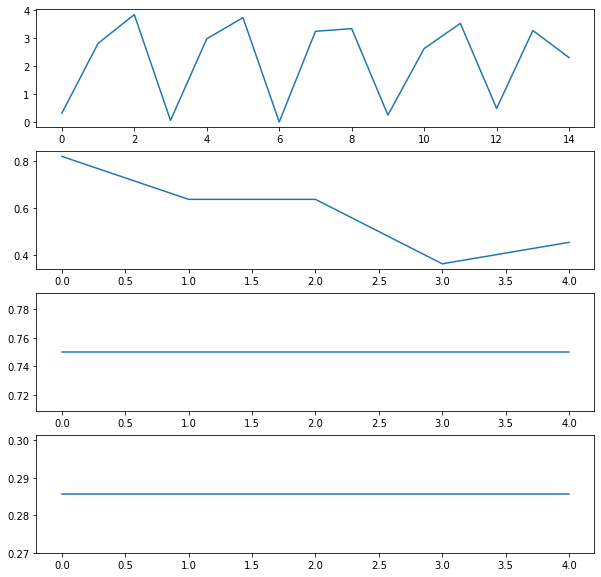

In [24]:
plt_list = [losses, accuracy, sensitivity, specificity]
plt.figure(figsize = (10, 10))
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.plot(plt_list[i])

## ROC曲线可视化


ROC曲线下的面积为AUC，这个面积（下面打印的结果）如果大于0.5就证明具有一定价值，越接近1越好。如果实验完全随机，那么面积就等于0.5，就相当于p用没有

0.5919466666666667


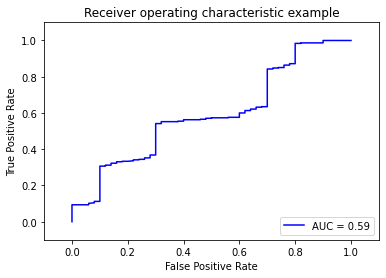

In [25]:
# coding=UTF-8
from sklearn import metrics
import matplotlib.pylab as pylab

# 这个GTlist是真实标签
GTlist = labels
# 这个是预测值，
Problist = preds



## 下面的不要改变
fpr, tpr, thresholds = metrics.roc_curve(GTlist, Problist, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)  #auc为Roc曲线下的面积
print(roc_auc)

 
pylab.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
pylab.legend(loc='lower right')
# plt.plot([0, 1], [0, 1], 'r--')
pylab.xlim([-0.1, 1.1])
pylab.ylim([-0.1, 1.1])
pylab.xlabel('False Positive Rate') #横坐标是fpr
pylab.ylabel('True Positive Rate')  #纵坐标是tpr
pylab.title('Receiver operating characteristic example')
pylab.show()

## 当所有超参数调整好的时候，在测试集上运行一次，作为最终的accuracy，请记录下来

In [26]:
acc, sen, spe = evaluate_accuracy(test_loader, xx)
print('Accuracy on test set:{}, \tSensitivity on test set:{}, \tSpecificity on test set:{}'.format(acc, sen, spe))

total validation set data:11, numbers of accurately labeled data:7
Accuracy on test set:0.6363636255264282, 	Sensitivity on test set:0.5, 	Specificity on test set:0.0


In [30]:
acc, sen, spe = evaluate_accuracy(total_loader, xx)
print('Accuracy on total set:{}, \tSensitivity on test set:{}, \tSpecificity on test set:{}'.format(acc, sen, spe))

total validation set data:107, numbers of accurately labeled data:30
Accuracy on total set:0.28037381172180176, 	Sensitivity on test set:0.6385542168674698, 	Specificity on test set:0.20833333333333334


In [ ]:
# ################################### test
# # clf = SVC(kernel='linear')
# # clf.fit(x_total, y_total)
# # pred = clf.predict(x_total)
# print(np.sum(preds==labels))
# # print(f"Classification report for classifier {xx>0.5}:\n"
# #       f"{metrics.classification_report(labels, preds)}\n")
# disp = metrics.plot_confusion_matrix(xx, x_train, y_train)
# disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

# plt.show()

# ADNI

In [ ]:
data_adni = sio.loadmat('ADNI.mat')
x_positive = data_adni['NC']
x_negative = data_adni['AD']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = x_positive.shape[1]
print('x原本是只有一个特征的，为294维')
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)

# FTD_90_200_fMRI

In [ ]:
data_ftd = sio.loadmat('FTD_90_200_fMRI.mat')
x_positive = data_ftd['NC']
x_negative = data_ftd['FTD']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = x_positive.shape[1]
print('x原本是只有一个特征的，为294维')
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)